In [35]:
from hyrax import Hyrax

toml_path = "./baselinecls_testing_runtime_config.toml"
h = Hyrax(config_file=toml_path)
h.set_config("data_set.PhotoEventsDataset.use_oversampling", True)
dataset = h.prepare()

[2025-11-24 15:03:36,571 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.Adam.


[2025-11-24 15:03:36,572 hyrax.config_utils:INFO] Merging external default config from /home/drew/code/applecider/src/applecider/default_config.toml
[2025-11-24 15:03:36,928 hyrax.config_utils:WARNING] Runtime config contains key or section 'HyraxBaselineCLS' which has no default defined. All configuration keys and sections must be defined in /home/drew/code/hyrax/src/hyrax/hyrax_default_config.toml
[2025-11-24 15:03:36,929 hyrax.config_utils:WARNING] Runtime config contains key or section 'lr' which has no default defined. All configuration keys and sections must be defined in /home/drew/code/hyrax/src/hyrax/hyrax_default_config.toml
[2025-11-24 15:03:36,929 hyrax.config_utils:WARNING] Runtime config contains key or section 'train' which has no default defined. All configuration keys and sections must be defined in /home/drew/code/hyrax/src/hyrax/hyrax_default_config.toml
[2025-11-24 15:03:36,930 hyrax.config_utils:WARNING] Runtime config contains key or section 'validate' which has n

In [3]:
import pandas as pd
manifest_df = pd.read_csv("/Users/dbranton/lincc/incubators/photo_events/manifest_train.csv")

taxonomy_mapper = {0: 0,  # SN Ia -> SNI
                                1: 0,  # SN Ib -> SNI
                                2: 0,  # SN Ic -> SNI
                                3: 1,  # SN II -> SNII
                                4: 1,  # SN IIP -> SNII
                                5: 1,  # SN IIn -> SNII
                                6: 1,  # SN IIb -> SNII
                                7: 2,  # Cataclysmic -> CV
                                8: 3,  # AGN -> AGN
                                9: 4,  # Tidal Disruption Event -> TDE
                                }
manifest_df.sort_values("obj_id", inplace=True)

for i in range(10):
    if dataset['train'][i]['data']['label'] != taxonomy_mapper[manifest_df.iloc[i].label]:
        print(f"{dataset['train'][i]['object_id']}, {dataset['train'][i]['data']['label']}, {taxonomy_mapper[manifest_df.iloc[i].label]}")

ZTF18acslbve, 0, 2
ZTF20abefaya, 0, 2
ZTF18aalataf, 2, 3
ZTF18abrqedj, 0, 2
ZTF19abcncdg, 0, 2
ZTF20abixkhh, 0, 2
ZTF19acjjwsy, 0, 3
ZTF18acqppuj, 1, 3
ZTF21acgqhru, 1, 2


In [11]:
manifest_df.query("obj_id == 'ZTF19aavnwzv'").iloc[0].label

np.int64(0)

In [2]:
count = 0
for i in range(len(dataset["train"])):
    if dataset["train"][i]["data"]["label"] == 4:
        count += 1
print(count/len(dataset["train"]))
print(count)

0.2
6233


In [2]:
dataset["train"].prepped_datasets["data"].additional_samples_per_class


array([343, 118, 238,   0])

In [2]:
len(dataset["train"])

18699

In [5]:
dataset["train"].prepped_datasets["data"].class_at_index

AttributeError: 'PhotoEventsDataset' object has no attribute 'class_at_index'

In [13]:
dataset["train"][0]["data"]["photometry"][:, 4:7][20:40]

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [2]:
dataset["train"][0]

{'data': {'photometry': tensor([[0.0000e+00, 0.0000e+00, 1.7385e+00,  ..., 0.0000e+00, 1.0000e+00,
           0.0000e+00],
          [9.6896e-01, 9.6896e-01, 1.7558e+00,  ..., 0.0000e+00, 1.0000e+00,
           0.0000e+00],
          [1.9694e+00, 1.0004e+00, 1.7727e+00,  ..., 0.0000e+00, 1.0000e+00,
           0.0000e+00],
          ...,
          [2.2090e+03, 4.3310e-02, 1.7420e+00,  ..., 0.0000e+00, 1.0000e+00,
           0.0000e+00],
          [2.2109e+03, 1.9731e+00, 2.3498e+00,  ..., 1.0000e+00, 0.0000e+00,
           0.0000e+00],
          [2.2110e+03, 2.3079e-02, 1.6762e+00,  ..., 0.0000e+00, 1.0000e+00,
           0.0000e+00]]),
  'label': 1,
  'mean': array([[[3.2246544 , 0.7540643 , 1.8746203 , 0.05986896]]], dtype=float32),
  'std': array([[[1.1197147 , 0.7268315 , 0.415058  , 0.03053633]]], dtype=float32)},
 'object_id': 'ZTF23abkixfb'}

In [3]:
dataset["infer"][0]

{'data': {'photometry': tensor([[0.0000e+00, 0.0000e+00, 1.5042e+00,  ..., 1.0000e+00, 0.0000e+00,
           0.0000e+00],
          [2.8103e+00, 2.8103e+00, 1.7056e+00,  ..., 0.0000e+00, 1.0000e+00,
           0.0000e+00],
          [2.8954e+00, 8.5150e-02, 1.5262e+00,  ..., 1.0000e+00, 0.0000e+00,
           0.0000e+00],
          ...,
          [1.8070e+03, 3.0318e+00, 1.5418e+00,  ..., 1.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.8079e+03, 9.5059e-01, 1.4949e+00,  ..., 1.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.8089e+03, 9.9870e-01, 1.5040e+00,  ..., 1.0000e+00, 0.0000e+00,
           0.0000e+00]]),
  'label': 3,
  'mean': array([[[3.2246544 , 0.7540643 , 1.8746203 , 0.05986896]]], dtype=float32),
  'std': array([[[1.1197147 , 0.7268315 , 0.415058  , 0.03053633]]], dtype=float32)},
 'object_id': 'ZTF19adiofhy'}

In [4]:
dataset["infer"].prepped_datasets["data"].manifest_df

,obj_id,filepath,label,n_events,split
0,ZTF19adiofhy,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,586,test
1,ZTF20aavhyel,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,2,35,test
2,ZTF19aalbjwb,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,261,test
3,ZTF19abycslo,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,0,48,test
4,ZTF20acurrzb,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,0,42,test
...,...,...,...,...,...
2732,ZTF18acefilj,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,360,test
2733,ZTF19abiterg,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,911,test
2734,ZTF19aavyjdn,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,19,test
2735,ZTF18abzqpvo,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,36,test


In [36]:
h.train()

[2025-11-24 15:03:43,598 hyrax.models.model_registry:WARNING] Both model and config define an optimizer. Hyrax will use self.optimizer defined in the model.
[2025-11-24 15:03:43,599 hyrax.models.model_registry:INFO] Using self.optimizer defined in model: torch.optim.adam.Adam
[2025-11-24 15:03:43,599 hyrax.models.model_registry:WARNING] Both model and config define a criterion. Hyrax will use self.criterion defined in the model.
[2025-11-24 15:03:43,599 hyrax.models.model_registry:INFO] Using self.criterion defined in model: applecider.models.HyraxBaselineCLS.FocalLoss
[2025-11-24 15:03:43,600 hyrax.verbs.train:INFO] Training model: HyraxBaselineCLS
[2025-11-24 15:03:43,600 hyrax.verbs.train:INFO] Training dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: applecider.datasets.photo_dataset.PhotoEventsDataset
  Data location: ../../../data/photo_events/train/
  Primary ID field: object_id
  Requested fields: photometry, label, mean, std
  Dataset config:
    manifest_pa

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

  1%|          | 1/147 [00:00<?, ?it/s]

[2025-11-24 15:09:12,964 hyrax.pytorch_ignite:INFO] Total training time: 329.34[s]
2025/11/24 15:09:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/11/24 15:09:12 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-11-24 15:09:12,981 hyrax.verbs.train:INFO] Finished Training


HyraxBaselineCLS(
  (criterion): FocalLoss()
  (in_proj): Linear(in_features=7, out_features=128, bias=True)
  (time2vec): Time2Vec()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=5, bias=True)
  (fc): Linear(in_features=128, out_

In [37]:
i_ds = h.infer()

[2025-11-24 15:09:18,021 hyrax.models.model_registry:WARNING] Both model and config define an optimizer. Hyrax will use self.optimizer defined in the model.
[2025-11-24 15:09:18,022 hyrax.models.model_registry:INFO] Using self.optimizer defined in model: torch.optim.adam.Adam
[2025-11-24 15:09:18,023 hyrax.models.model_registry:WARNING] Both model and config define a criterion. Hyrax will use self.criterion defined in the model.
[2025-11-24 15:09:18,023 hyrax.models.model_registry:INFO] Using self.criterion defined in model: applecider.models.HyraxBaselineCLS.FocalLoss
[2025-11-24 15:09:18,023 hyrax.verbs.infer:INFO] Inference model: HyraxBaselineCLS
[2025-11-24 15:09:18,024 hyrax.verbs.infer:INFO] Inference dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: applecider.datasets.photo_dataset.PhotoEventsDataset
  Data location: ../../../data/photo_events/train/
  Primary ID field: object_id
  Requested fields: photometry, label, mean, std
  Dataset config:
    manifest_

  3%|3         | 1/32 [00:00<?, ?it/s]

[2025-11-24 15:09:20,883 hyrax.pytorch_ignite:INFO] Total evaluation time: 2.39[s]
[2025-11-24 15:09:22,305 hyrax.verbs.infer:INFO] Inference Complete.


In [38]:
# Get the predicted classes for each of the inference results
#! Note that we need to apply softmax to the output tensors to get probabilities
import torch
import torch.nn.functional as F
import numpy as np
res_list = []

for i in range(32):
    a = np.load(f"/home/drew/code/applecider/docs/pre_executed/testing/results/20251124-150917-infer-LuHy/batch_{i}.npy")

    for i in a:
        max_ind = np.argmax(F.softmax(torch.as_tensor(i['tensor']), dim=0).numpy())
        res_list.append((str(i['id']), int(max_ind)))

In [39]:
# Get the known classes for each of the inference results


import pandas as pd
manifest_df = pd.read_csv("../../../data/photo_events/manifest_test.csv")

taxonomy_mapper = {0: 0,  # SN Ia -> SNI
                                1: 0,  # SN Ib -> SNI
                                2: 0,  # SN Ic -> SNI
                                3: 1,  # SN II -> SNII
                                4: 1,  # SN IIP -> SNII
                                5: 1,  # SN IIn -> SNII
                                6: 1,  # SN IIb -> SNII
                                7: 2,  # Cataclysmic -> CV
                                8: 3,  # AGN -> AGN
                                9: 4,  # Tidal Disruption Event -> TDE
                                }

pred_class = []
real_class = []
for id, pred in res_list:
    pred_class.append(pred)
    row = manifest_df[manifest_df["obj_id"] == id]
    real_class.append(taxonomy_mapper[row.iloc[0].label])


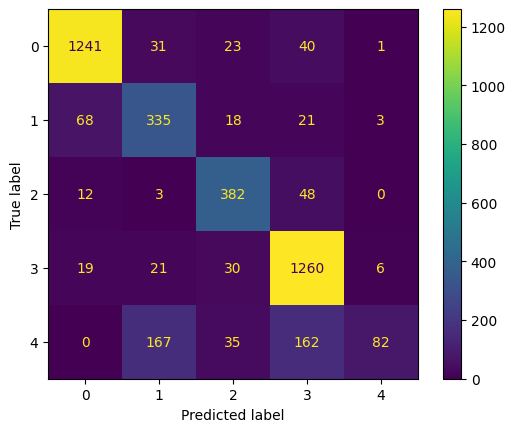

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(real_class, pred_class)).plot()